In [ ]:
!pip install pytorch-lightning --q
!pip install ray
!pip install ray[serve]
!pip install -U tensorboardx
!pip install torchvision
!pip install tensorrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 9.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 134.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 55.9 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling g

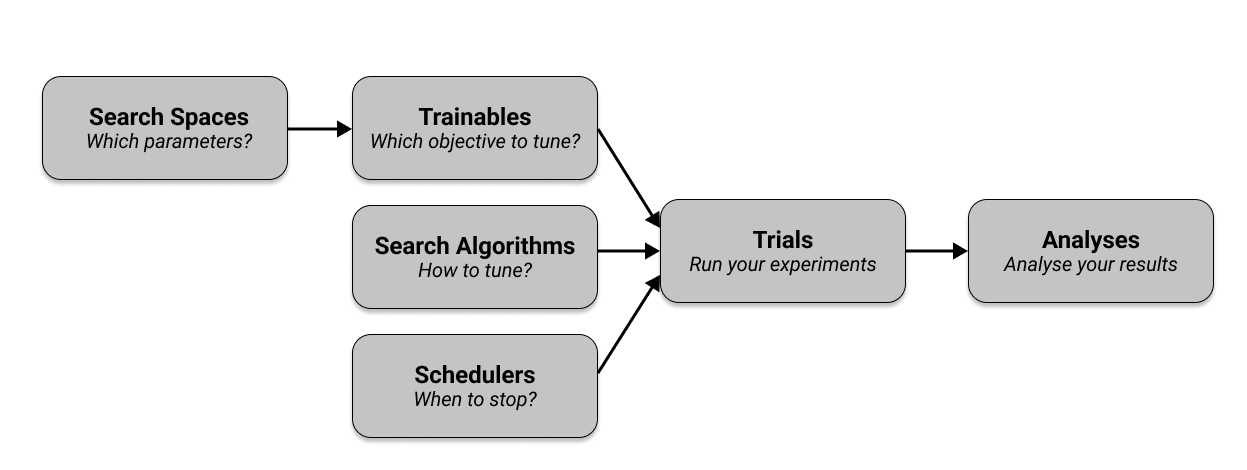

In [ ]:
import torch
import torch.optim as optim

import ray
from ray import air, tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.examples.mnist_pytorch import train, test, get_data_loaders, ConvNet


EPOCH_SIZE = 512
TEST_SIZE = 256

class TrainMNIST(tune.Trainable):
    def setup(self, config):
        use_cuda = config.get("use_gpu") and torch.cuda.is_available()
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.train_loader, self.test_loader = get_data_loaders()
        self.model = ConvNet().to(self.device)
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=config.get("lr", 0.01),
            momentum=config.get("momentum", 0.9))

    def step(self):
        train(
            self.model, self.optimizer, self.train_loader, device=self.device
        )
        acc = test(self.model, self.test_loader, self.device)
        return {"mean_accuracy": acc}

    def save_checkpoint(self, checkpoint_dir):
        checkpoint_path = os.path.join(checkpoint_dir, "model.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return checkpoint_path

    def load_checkpoint(self, checkpoint_path):
        self.model.load_state_dict(torch.load(checkpoint_path))



sched = ASHAScheduler()

tuner = tune.Tuner(
    tune.with_resources(
        TrainMNIST, 
        resources={"cpu": 2, "gpu": 0}),
    run_config=air.RunConfig(
        stop={
            "mean_accuracy": 0.95,
            "training_iteration": 20,
        },
        checkpoint_config=air.CheckpointConfig(
            checkpoint_at_end=True, checkpoint_frequency=3
        ),
    ),
    tune_config=tune.TuneConfig(
        metric="mean_accuracy",
        mode="max",
        scheduler=sched,
        num_samples = 20,
    ),
    param_space={
        "lr": tune.uniform(0.001, 0.1),
        "momentum": tune.uniform(0.1, 0.9),
    },
)
results = tuner.fit()

print("Best config is:", results.get_best_result().config)